In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from rubin_sim.utils import calcSeason, ddf_locations


In [2]:
ddf_name = "ELAISS1"
ddfs = ddf_locations()
ddf_RA = ddfs[ddf_name][0]

ddf_data = np.load('ddf_grid.npz')
ddf_grid = ddf_data['ddf_grid'].copy()
sun_limit=np.radians(-18)
airmass_limit=2.1
sky_limit=21.75
season_frac = 0.2
sequence_limit=286
low_season_rate=0.3
low_season_frac=0.4

# XXX-- double check that I got this right
ack = ddf_grid['sun_alt'][0:-1] * ddf_grid['sun_alt'][1:]
night = np.zeros(ddf_grid.size, dtype=int)
night[np.where((ddf_grid['sun_alt'][1:] >= 0) & (ack < 0))] += 1
night = np.cumsum(night)
ngrid = ddf_grid['mjd'].size


In [3]:
# set a sun, airmass, sky masks
sun_mask = np.ones(ngrid, dtype=int)
sun_mask[np.where(ddf_grid['sun_alt'] >= sun_limit)] = 0

airmass_mask = np.ones(ngrid, dtype=int)
airmass_mask[np.where(ddf_grid['%s_airmass' % ddf_name] >= airmass_limit)] = 0

sky_mask = np.ones(ngrid, dtype=int)
sky_mask[np.where(ddf_grid['%s_sky_g' % ddf_name] <= sky_limit)] = 0
sky_mask[np.where(np.isnan(ddf_grid['%s_sky_g' % ddf_name]) == True)] = 0

m5_mask = np.zeros(ngrid, dtype=bool)
m5_mask[np.isfinite(ddf_grid['%s_m5_g' % ddf_name])] = 1

big_mask = sun_mask * airmass_mask * sky_mask * m5_mask

In [4]:
potential_nights = np.unique(night[np.where(big_mask > 0)] )

In [5]:
# prevent a repeat sequence in a night
unights, indx = np.unique(night, return_index=True)
night_mjd = ddf_grid['mjd'][indx]
# The season of each night
night_season = calcSeason(ddf_RA, night_mjd)

raw_obs = np.ones(unights.size)
# take out the ones that are out of season
season_mod = night_season % 1

 # Set a region to be a lower cadence. 
low_season = np.where((season_mod < low_season_frac) | (season_mod > (1.-low_season_frac)))
raw_obs[low_season] = low_season_rate

out_season = np.where((season_mod < season_frac) | (season_mod > (1.-season_frac)))
raw_obs[out_season] = 0
cumulative_desired = np.cumsum(raw_obs)
cumulative_desired = cumulative_desired/cumulative_desired.max()*sequence_limit
grad = np.diff(cumulative_desired)

# Makes it go blazing fast agian, that's for sure!
#cumulative_desired = np.round(cumulative_desired)

night_mask = unights*0
night_mask[potential_nights] = 1

# night_mask[np.where(raw_obs == 0)] = 0

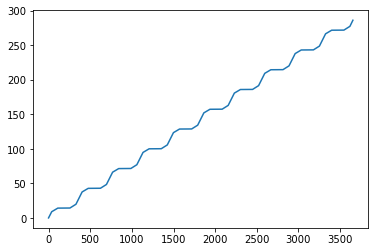

In [6]:
plt.plot(unights,cumulative_desired )

In [7]:
# Let's make an initial guess that we should schedule where the gradiant is positive and the mask is 1
potential_indx = np.where((np.concatenate([np.array([1]),grad]) > 0) & (night_mask > 0))[0]

# Let's just uniformly sample out potential_indx array to construct our initial guess
x0 = potential_indx[np.linspace(0,potential_indx.size-1, num=sequence_limit).astype(int)]

In [8]:
schedule = unights*0
schedule[x0] = 1

In [9]:
def iterate_schedule(in_schedule, cumulative_desired, mask):
    """Adjust the schedule so it's closer to the desired schedule
    """
    # copy so we don't edit in place
    schedule = in_schedule + 0
    
    cumulative_sched = np.cumsum(schedule)
    # Where diff is very negative, we hav too many observations,
    # Where it is positive, we need more observations
    diff = cumulative_desired - cumulative_sched
    over = np.min(np.where(diff == diff.min())[0])
    # find potential places to move the value to
    under = np.where((mask == 1) & (schedule == 0))[0]
    
    #import pdb ; pdb.set_trace()
    under = np.where(under > over)[0]
    counter = 0
    
    
    while (np.size(under) > 0) & (counter < 100) :
        indx = np.min(under) #np.where(diff == diff[under].max())[0]
        if np.size(indx) == 0:
            return schedule
        else:
            indx = np.min(indx)
            
        #if counter == 100:
        #    import pdb ; pdb.set_trace()
        schedule[over] -= 1
        schedule[indx] += 1
        
        cumulative_sched = np.cumsum(schedule)
        diff = cumulative_desired - cumulative_sched
        over = np.min(np.where(diff == diff.min())[0])
        under = np.where((mask == 1) & (schedule == 0))[0]
        
        counter += 1
        
    #import pdb ; pdb.set_trace()
    return schedule
            
    

In [10]:
result = iterate_schedule(schedule, cumulative_desired, night_mask)

In [11]:
result

array([1, 1, 1, ..., 0, 1, 0])

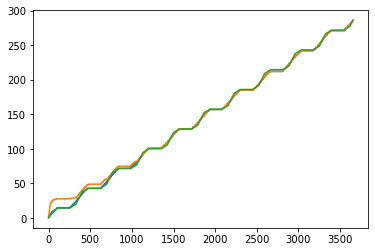

In [12]:
plt.plot(np.cumsum(schedule))
plt.plot(np.cumsum(result))
plt.plot(unights,cumulative_desired )

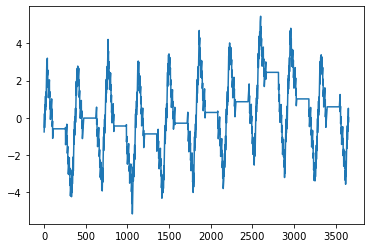

In [13]:
plt.plot(cumulative_desired - np.cumsum(schedule))

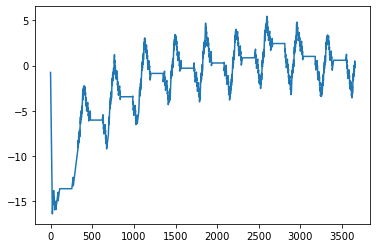

In [14]:
plt.plot(cumulative_desired - np.cumsum(result))

In [15]:
diff = cumulative_desired - np.cumsum(schedule)

In [16]:
np.where(diff == np.min(diff))

(array([1058]),)

In [17]:
np.where(diff == np.max(diff))

(array([2598]),)

In [18]:
schedule[1058] -= 1
schedule[2598] += 1

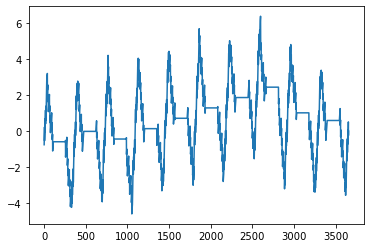

In [19]:
plt.plot(cumulative_desired - np.cumsum(schedule))

In [20]:
# ok ok, take the spot where the diff goes negative. push that observation forward to the next available spot

In [21]:
round_desired = np.round(cumulative_desired)

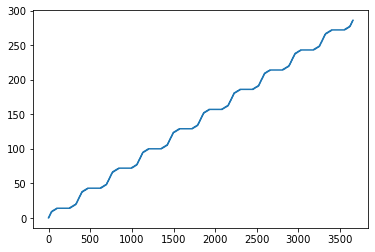

In [22]:
plt.plot(round_desired)

In [23]:
round_desired

array([  0.,   0.,   1., ..., 286., 286., 286.])

In [24]:
drd = np.diff(round_desired)

In [25]:
drd

array([0., 1., 0., ..., 1., 0., 0.])

In [26]:
step_points = np.where(drd > 0)[0] + 1

In [27]:
step_points

array([   2,    6,   10,   14,   18,   22,   26,   30,   34,   43,   56,
         70,   83,   97,  257,  270,  284,  298,  311,  325,  331,  336,
        340,  344,  348,  352,  356,  360,  364,  368,  372,  376,  381,
        385,  389,  393,  397,  401,  413,  427,  441,  454,  468,  629,
        642,  656,  669,  683,  695,  699,  703,  707,  711,  716,  720,
        724,  728,  732,  736,  740,  744,  748,  752,  756,  761,  765,
        772,  785,  799,  812,  826,  840,  999, 1013, 1027, 1040, 1054,
       1062, 1066, 1070, 1074, 1078, 1082, 1086, 1090, 1095, 1099, 1103,
       1107, 1111, 1115, 1119, 1123, 1127, 1131, 1142, 1156, 1170, 1183,
       1197, 1356, 1370, 1384, 1397, 1411, 1425, 1429, 1433, 1437, 1441,
       1445, 1449, 1453, 1457, 1461, 1465, 1469, 1474, 1478, 1482, 1486,
       1490, 1494, 1499, 1513, 1527, 1540, 1554, 1568, 1727, 1741, 1754,
       1768, 1782, 1791, 1795, 1799, 1804, 1808, 1812, 1816, 1820, 1824,
       1828, 1832, 1836, 1840, 1844, 1848, 1853, 18

In [28]:
# So, I'd like to place an observation at the nearest possible step point

sched = round_desired*0

x=np.arange(sched.size)
valid = np.where(night_mask > 0)[0]

for indx in step_points:
    # Could probably do this faster with searchsorted. Maybe also even remove the 
    # point from the valid array if needed.
    dist = np.abs(x[valid] - indx)
    best = np.min(np.where(dist == np.min(dist))[0])
    sched[valid[best]] += 1

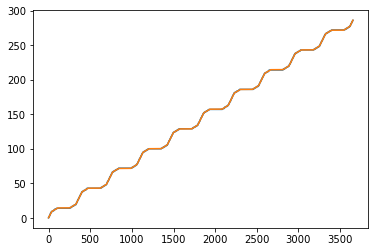

In [29]:
plt.plot(np.cumsum(sched))
plt.plot(cumulative_desired)

In [30]:
np.cumsum(sched)

array([  0.,   0.,   1., ..., 286., 286., 286.])

In [31]:
sched = round_desired*0

x=np.arange(sched.size)
valid = np.where(night_mask > 0)[0]

left = np.searchsorted(x[valid], step_points)
right = np.searchsorted(x[valid], step_points, side='right')

d1 = np.abs(x[valid[left]] - step_points)
d2 = np.abs(x[valid[right]] - step_points)

In [32]:
sched[valid[left[np.where(d1 <= d2)[0]]]] += 1
sched[valid[right[np.where(d1 > d2)[0]]]] += 1


In [33]:
left[np.where(d1 <= d2)[0]].shape

(286,)

In [34]:
# ah, can't just use searchsorted because we have duplicate indices
left[np.where(d1 <= d2)[0]]

array([   2,    6,   10,   14,   18,   22,   25,   25,   29,   38,   47,
         57,   66,   74,  115,  121,  132,  140,  151,  161,  164,  169,
        173,  177,  181,  184,  185,  189,  193,  197,  201,  205,  209,
        210,  214,  218,  222,  226,  233,  246,  254,  264,  273,  316,
        329,  334,  347,  354,  366,  370,  374,  376,  376,  381,  385,
        389,  393,  397,  400,  401,  405,  409,  413,  417,  422,  425,
        429,  442,  449,  462,  468,  480,  519,  523,  537,  541,  555,
        561,  561,  565,  569,  573,  577,  581,  584,  585,  589,  593,
        597,  601,  605,  609,  609,  613,  617,  628,  636,  650,  655,
        669,  710,  714,  728,  731,  745,  752,  756,  760,  764,  768,
        770,  770,  774,  778,  782,  786,  790,  794,  794,  798,  802,
        806,  810,  815,  824,  838,  843,  857,  860,  908,  920,  925,
        939,  945,  954,  958,  961,  961,  965,  969,  973,  977,  981,
        984,  984,  988,  992,  996, 1000, 1005, 10

In [35]:
from match_cumulative import match_cumulative

ack = match_cumulative(cumulative_desired, mask=night_mask)

In [36]:
ack

array([0., 0., 1., ..., 0., 1., 0.])

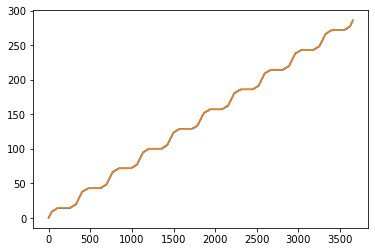

In [37]:
plt.plot(np.cumsum(ack))
plt.plot(cumulative_desired)

(0.0, 50.0)

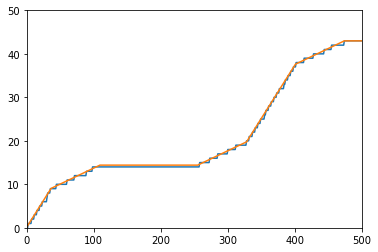

In [38]:
plt.plot(np.cumsum(ack))
plt.plot(cumulative_desired)
plt.xlim([0,500])
plt.ylim([0,50])